# CS523 Demo

## Imports & Requirements

In [21]:
#!pip install wfdb
#!pip install tensorflow_addons
#!pip install ecg_plot

#from google.colab import drive
#drive.mount('/content/drive/')
#import sys
#sys.path.insert(0,'/content/drive/MyDrive/COLAB')

#Change to physionet_utilities
import physionet_utilities as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

## ECG Sample Plot

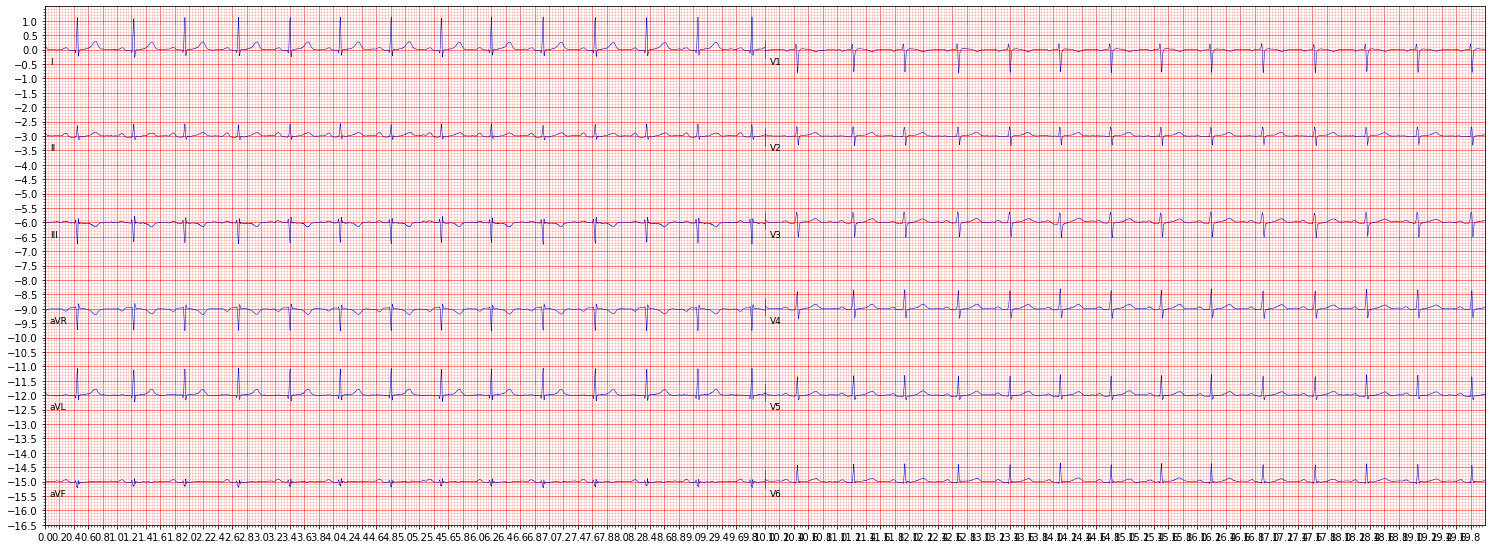

In [22]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()
plot_ecg("input/GeorgiaDB/E00001.mat")

## Data

<AxesSubplot:>

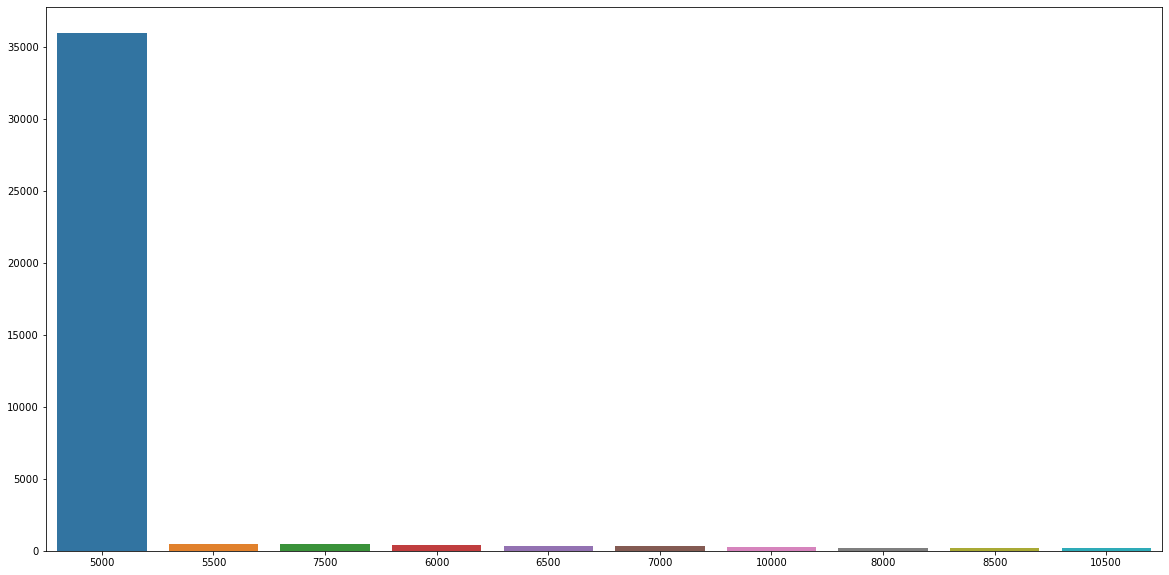

In [23]:
gender, age, labels, ecg_filenames = pc.import_key_data("input/")
ecg_filenames = np.asarray(ecg_filenames)

import os
signal_lenght=[]
for subdir, dirs, files in sorted(os.walk("input/")):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".mat"):
            data, header_data = pc.load_challenge_data(filepath)
            splitted = header_data[0].split()
            signal_lenght.append(splitted[3])
signal_lenght_df = pd.DataFrame(signal_lenght)
signal_count=signal_lenght_df[0].value_counts()
plt.figure(figsize=(20,10))
#plt.title(title,fontsize =36)
sns.barplot(signal_count[:10,].index, signal_count[:10,].values)


In [4]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 42585
age data shape: 42585


In [24]:

SNOMED_scored=pd.read_csv("input/mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("input/mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)


y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


### Diagnosis Distribution

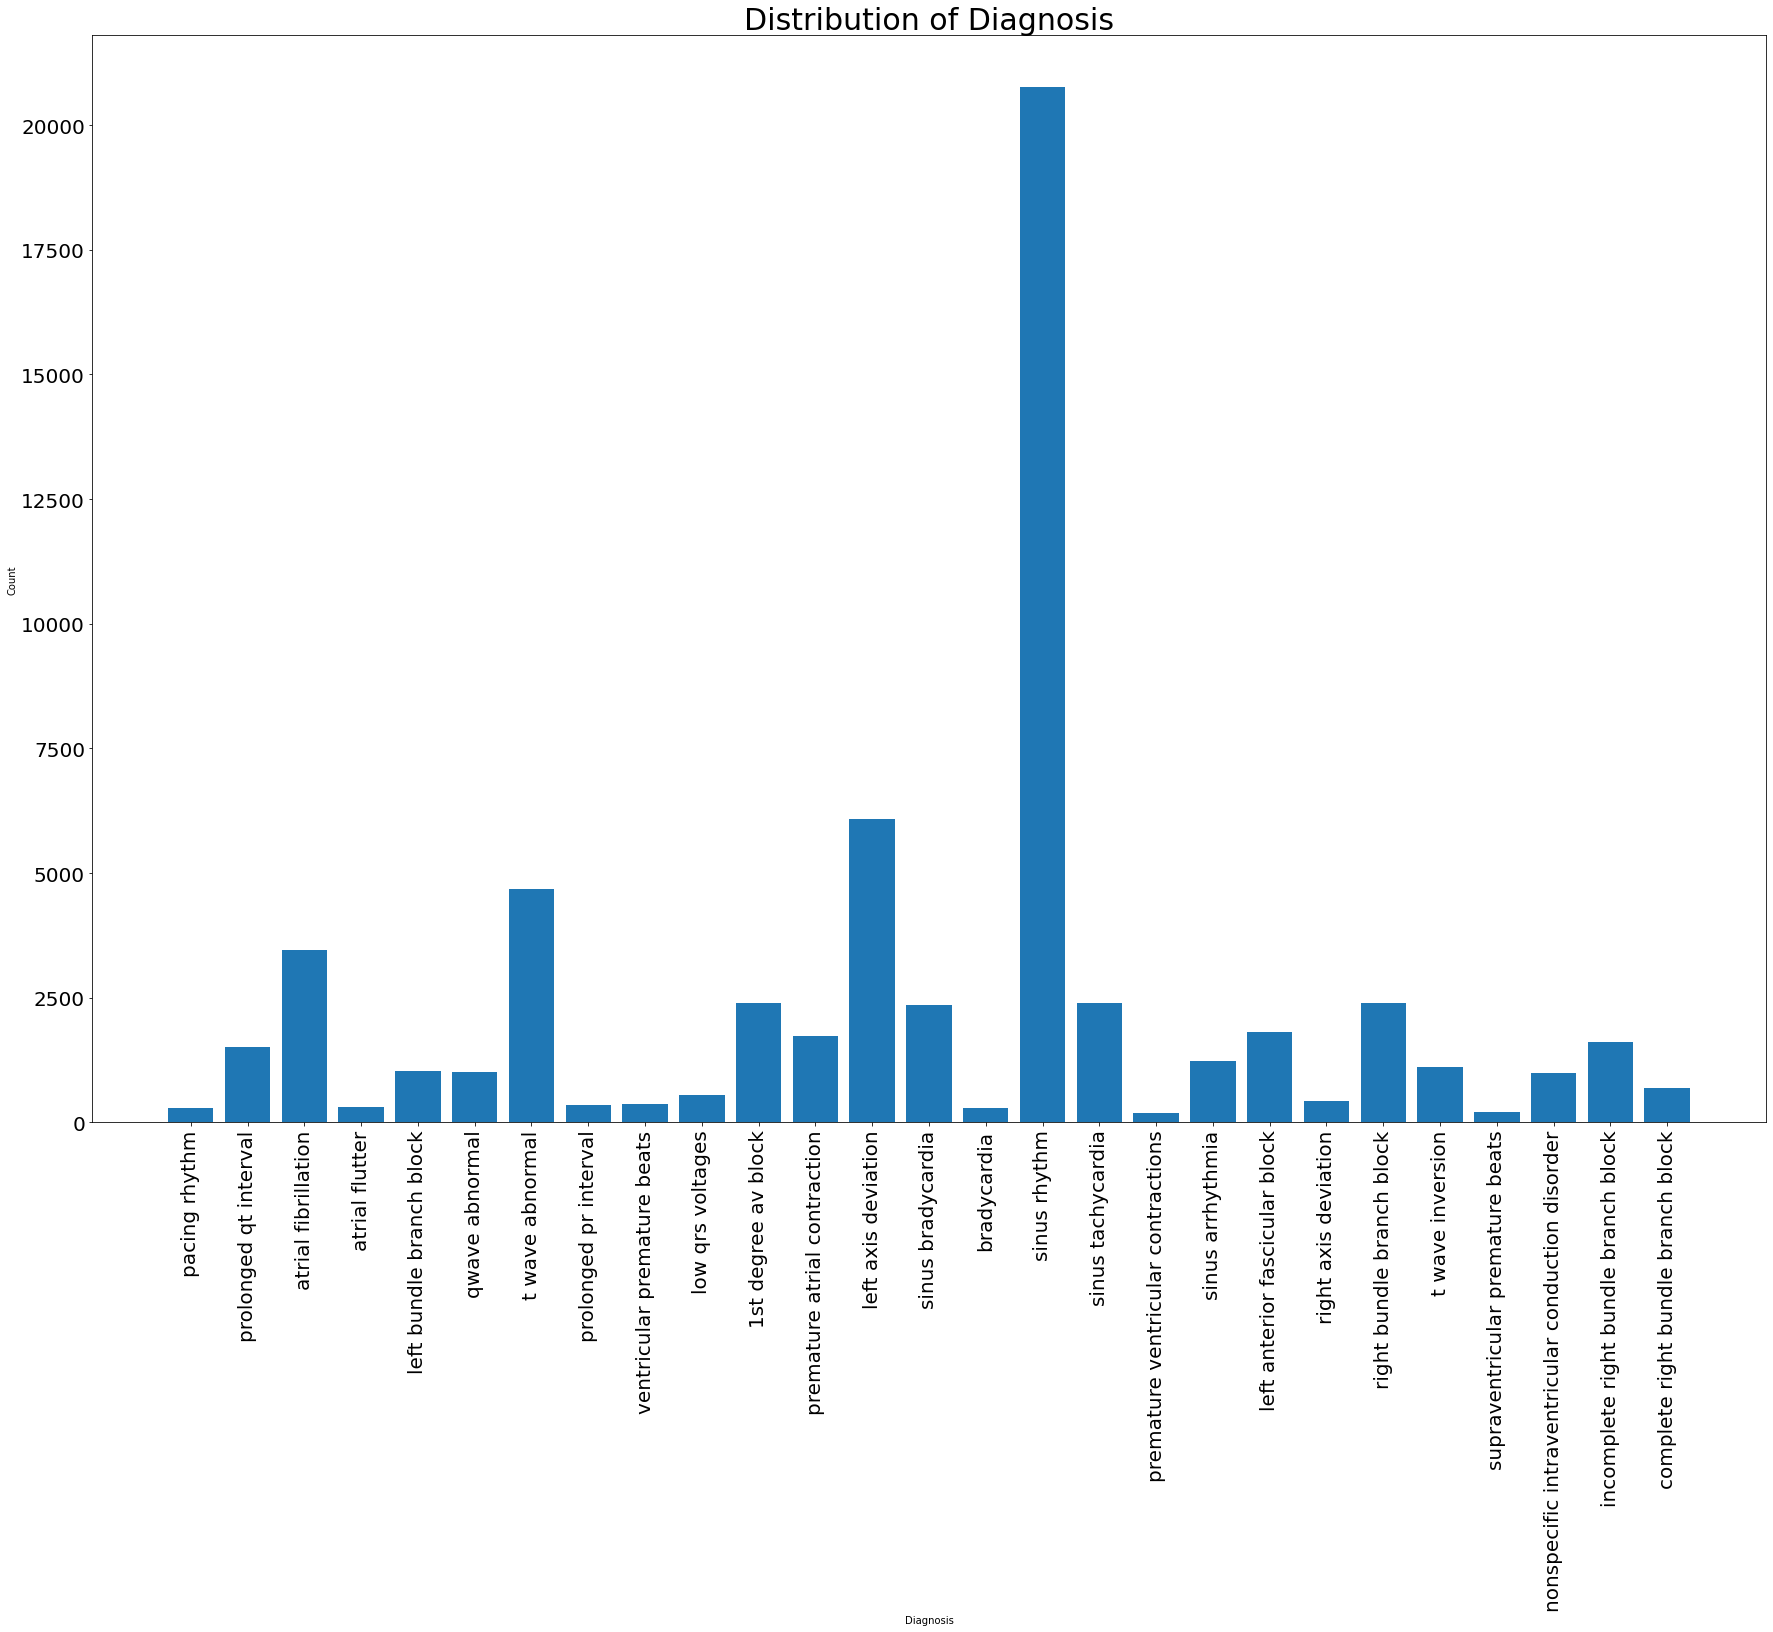

In [25]:

snomed_abbr = []
for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)

pc.plot_classes(snomed_classes, SNOMED_scored,y)

### K-Folds Split

In [26]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))



Total number of unique combinations of diagnosis: 1414


In [27]:

folds = pc.split_data(labels, y_all_comb)

Training split: 38326
Validation split: 4259


### Batch-Generator

In [28]:
order_array = folds[0][0]

In [29]:

def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

### Weight calculation

In [30]:
new_weights=pc.calculating_class_weights(y)

keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

#total = sum(list(weight_dictionary.values()))
#labels = []
#sizes = []

#for x, y in weight_dictionary.items():
#    labels.append(x)
#    sizes.append(y/total)

# Plot
#plt.figure(figsize=(9, 9))
#plt.pie(sizes, labels=snomed_abbr)
#plt.axis('equal')
#plt.show()


{0: 71.2123745819398,
 1: 14.073033707865168,
 2: 6.153901734104046,
 3: 68.02715654952077,
 4: 20.453890489913544,
 5: 21.019249753208292,
 6: 4.556494757115344,
 7: 62.625,
 8: 58.33561643835616,
 9: 38.29586330935252,
 10: 8.894110275689224,
 11: 12.314921920185078,
 12: 3.4986033519553073,
 13: 9.026070368800339,
 14: 73.93229166666667,
 15: 1.0253539439468362,
 16: 8.868179925031237,
 17: 113.25797872340425,
 18: 17.171370967741936,
 19: 11.789867109634551,
 20: 49.86533957845433,
 21: 8.864487926727726,
 22: 19.14793165467626,
 23: 99.03488372093024,
 24: 21.35656970912738,
 25: 13.216945996275605,
 26: 31.174963396778917}

### Learning Rate Reduction

In [31]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [32]:
from scipy import optimize

def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

## Model

In [33]:
def CNN_model():
    inputlayer = keras.layers.Input(shape=(5000,12)) 

    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputlayer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

    #Change to softmax
    outputlayer = keras.layers.Dense(27, activation='sigmoid')(gap_layer)

    model = keras.Model(inputs=inputlayer, outputs=outputlayer)
  


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

    return model

In [34]:
model = pc.residual_network_1d()

(array([    0,     1,     2, ..., 42582, 42583, 42584]), array([    8,     9,    14, ..., 42564, 42574, 42576]))


## Training

### Fitting

In [16]:

batchsize = 30

model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y)), epochs=100,verbose=1, steps_per_epoch=(len(order_array)/batchsize), validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])

Epoch 1/100
  31/1277 [..............................] - ETA: 64:46:59 - loss: 7.5049 - accuracy: 0.9449 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - AUC: 0.4923

KeyboardInterrupt: 

### Or loading weights

In [35]:
model.load_weights("resnet_model.h5")

In [36]:
y_pred = model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

init_thresholds = np.arange(0,1,0.05)

all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1])


0.15308402697860948
0.32875918841264007
0.34985584728875585
0.2940206955766956
0.19595443760533293
0.07997571845651817
-0.02185702814827151
-0.13204143650107408
-0.22888349921086848
-0.3227451291235877
-0.4045975865789842
-0.4791398979592908
-0.54519340814365
-0.6133984144263117
-0.6705016453234677
-0.7157237223532422
-0.7516268951381696
-0.7782523941552397
-0.7980536368966347
-0.8164122211659212


### Optimization

In [37]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))#
print(pc.compute_challenge_metric_for_opt(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))#

Optimization terminated successfully.
         Current function value: -0.352572
         Iterations: 119
         Function evaluations: 338
0.35257232338858563


## Results

### Confusion Matrix

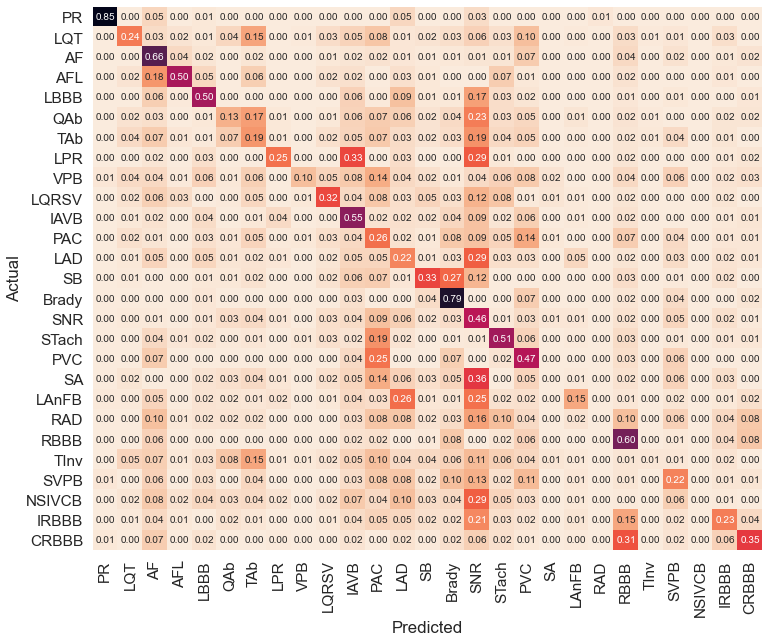

In [38]:
pc.plot_normalized_conf_matrix(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes,snomed_abbr)
plt.savefig("confusion_matrix_fcn.png", dpi = 100)